# Run and calibrate the WOFOST phenology model based on local data for Switzerland

This Notebook uses the WOFOST phenology model (Wofost72_Phenology) to simulate the heading date of a selected winter wheat variety (here: Arina). It uses observational data from 2000-2018 from a range of Swiss field sites [Source: Dario Fossati, Agroscope; Data used in [Rogger et al. 2021](https://www.sciencedirect.com/science/article/pii/S1161030121001659)] to calibrate the temperature sum from emergence to anthesis (TSUM1). 

First, we need to declare some important functions to read and prepare the data in order use it later. 

To run the WOFOST phenology module we need to specify the following input

- **Crop parameters**: consist of parameter names and the corresponding parameter values that are needed to parameterize the components of the crop simulation model. They can be downloaded [here](https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/). 

- **Agromanagement**:
These parameters characterize the crop calendar and events (such as, e.g. irrigation). For the most basic set up, only crop calender is needed

- **Weather data**:
daily weather data of Tmin and Tmax. Other weather data is not used by the phenology model but needs to be specified nonetheless. Hence, we just use some dummy data.

**Author**: Raphael Portmann, raphael.portmann@agroscope.admin.ch



In [9]:
%matplotlib inline
import sys, os
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
import pandas as pd
import pcse
import xarray as xr
import numpy as np
import scipy


print("This notebook was built with:")
print("python version: %s " % sys.version)
print("PCSE version: %s" %  pcse.__version__)

#%% Read data  
def read_data_Fossati(variety):
    
    """ Read data from Dario Fossati for further use for certain variety. 
    - Change "Harvestyear" to "year"
    
    Parameters
    ----------
        variety: str
            Wheat variety to be used for calibration
    
    Returns
    --------
        pheno_calib: pandas.DataFrame
            Dataframe that contains the data necessary for calibration
    
    """
    
    ###### Dario Fossati data
    
    # read phenology data for wheat
    datadir = 'C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/phenology/Fossati_Agroscope/Phenologie_Fossati_put_together_00_18.csv'
    data_Fossati = pd.read_csv(datadir, delimiter=';', header=0, encoding="ISO-8859-1")
    # rename
    data_Fossati = data_Fossati.rename(columns={"Harvestyear": "year"})

    if variety is not None:
        pheno_calib=data_Fossati.loc[(data_Fossati['Variety']==variety) & (data_Fossati['Heading'].isnull().values==False) & (data_Fossati['PLZ']!=1896)]
    else:
        pheno_calib=data_Fossati
    return pheno_calib



        
class wdp_from_MCH(pcse.base.WeatherDataProvider):
    
    """A weather data provider that uses Meteoswiss data (daily Tmin and Tmax) as input """
 
    def __init__(self, default_values,data_mch,elevation, start_day, end_day):
        super().__init__()
        
        lon=data_mch.lon.values
        lat=data_mch.lat.values
        
        self.elevation = elevation
        self.longitude = lon
        self.latitude = lat
 
        for d in pd.date_range(start_day, end_day):
            d1 = d.date()
            tmin=data_mch.TminD.sel(time=d).values
            tmax=data_mch.TmaxD.sel(time=d).values
            wdc = pcse.base.WeatherDataContainer(DAY=d1, LAT=lat, LON=lon, ELEV=elevation,TMIN=tmin,TMAX=tmax,
                                                 **default_values)
            self._store_WeatherDataContainer(wdc, d1)
 
 
def get_agromanagement_wheat(year):
    
        """ read agromanagement data for wheat and change it to fit with the current year
        
        Parameters
        ----------
            year: int
                current year (year of anthesis/harvest, NOT sowing)
        Returns
        -------
            agromanager: pcse.agromanager.AgroManager
                Agromanager to be used to run WOFOST for the current year
                
        """
        import yaml
        from yaml import CLoader as Loader, CDumper as Dumper
        import datetime
        
        data_dir = os.path.join(os.getcwd(), "data")
        
        #change year to sowing year
        year=year-1
        
        #open yaml textfile
        txt=open(data_dir+'/agro/'+'wheat_calendar.txt')
        yaml_agro=yaml.load(txt,Loader=Loader)
        
        #create start dates
        standard_date=list(yaml_agro['AgroManagement'][0].keys())[0]
        campaign_date=datetime.date(year,10,1)
        crop_start_date=datetime.date(year,10,15)

        #get campaign and replace dates
        yaml_agro['AgroManagement'][0][campaign_date]=yaml_agro['AgroManagement'][0].pop(standard_date)
        yaml_agro['AgroManagement'][0][campaign_date]['CropCalendar']['crop_start_date']=crop_start_date
        
        agromanager=yaml_agro #pcse.agromanager.AgroManager.initialize(yaml_agro)

        return agromanager

#%% running the model
def WOFOST_model(wdp,agro,crop,params,print_results=False, plot_results=False):
    
    """ Run the phenology module of the WOFOST model and set parameter TSUM1
    
    Parameters
    -----------
        wdp: pcse.base.WeatherDataProvider
            Weather Data with daily Tmin and Tmax and other dummy data
        agro: pcse.agromanager.AgroManager
            Agromanagement  definition (here: only Crop Calendar)
        crop: 
            cropdata with containing generic crop parameters.
        params: list of ints
            List with parameters for the phenology model (here: temperature from emergence to anthesis [TSUM1,])
        print_results: boolean
            Specifies whether or not to print the tail of the resulting dataframe (default is False)
        plot_results: boolean
            Specifies whether or not to plot the temporal evolution of the phenology variable DVS (default is False)
    Returns
    --------
    
        DOY_sim: int
            Anthesis date (day of the year)
    
    """
    

    from pcse.base import ParameterProvider
    from pcse.models import Wofost72_Phenology
    
    #change cropdata based on parameter value
    cropdata=cropd.copy()
    cropdata['TSUM1'] = params[0]
    parameters = ParameterProvider(cropdata=cropdata)
    
    #parameters from Ryan Conway
    # TSUM1: 974.     #! temperature sum from emergence to anthesis [cel d]
    #cropdata['TSUM2'] = 1012.    #! temperature sum from anthesis to maturity [cel d]
    

    #run simulation 
    wofsim = Wofost72_Phenology(parameters, wdp, agro)
    wofsim.run_till_terminate()
    
    #prepare results
    df_results = pd.DataFrame(wofsim.get_output())
    df_results = df_results.set_index("day")
    date_sim=df_results[df_results['DVS']==1].index.values[0]
    DOY_sim=pd.to_datetime(date_sim).dayofyear

    if print_results==True:
        wofsim.run_till_terminate()
        df_results = pd.DataFrame(wofsim.get_output())
        df_results = df_results.set_index("day")
        df_results.tail()
    
    if plot_results==True:
        fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,8))
        df_results['DVS'].plot(ax=axes[0], title="DVS")
        print(df_results[df_results['DVS']==1])
        fig.autofmt_xdate()
        
    return DOY_sim

#%% Calibration
def prep_data_for_calib(pheno_calib):
    
    """
    Prepare meteodata and phenological data to use for optimization model    
    
    Parameters
    ----------
    pheno_calib: pandas.Dataframe
        Dataframe with obs data: required columns are 'year' and 'Heading' 

    Returns
    ---------
    DOY_obs_dict: dict
            dictionary with PLZs_years as keys and observed heading DOY as entries
            
    """
    #years for which phenological data is available
    years=np.unique(pheno_calib['year'].values)
    
    #prepare output ddicts
    DOY_obs_dict={}                         
    n_dict={}
    for year in years:
        for PLZ in list(set(pheno_calib['PLZ'])):
            
  
            #get observed heading date (mean if several data with same year)
            doy_obs=pheno_calib.loc[(pheno_calib['year']==year) & (pheno_calib['PLZ']==PLZ)]['Heading'].mean()
            n=pheno_calib.loc[(pheno_calib['year']==year) & (pheno_calib['PLZ']==PLZ)]['Heading'].count()

            if np.isnan(doy_obs)!=True:
                
                #fill data
                key=str(PLZ)+'_'+str(year)
                DOY_obs_dict[key]=doy_obs
                n_dict[key]=n
            
    
    return DOY_obs_dict, n_dict

def rmse(params,wdp_dict,agro_dict, cropd, DOY_obs_dict):
    
    """
    Compute Root mean squared error of modeled Heading DOY based WOFOST and observed DOY
    
    Parameters
    ----------
    params: list
        list of parameters, here only TSUM1
    wdp_dict: dict of pd.Dataframes
        dictionary with years as keys and dataframe as entries, with columns "TEFF" containing effective temperatures and "DOY" containing the day of the year
    agro_dict:
    cropd:
    DOY_obs_dict: dict
        dictionary with years as keys and observed heading DOY as entries

    Returns
    ---------
        RMSE: float
            Root mean squared error of modeled Heading DOY and observed heading DOY.
    """
   
    import math 
    
    #prepare list of simulated and modeled values
    DOY_sim=[]
    DOY_obs=[]
    
    #loop over years and locations (keys)
    for key in DOY_obs_dict.keys():
            plz=int(key[0:4])
            year=int(key[5:9])
            if year>=2001:
                #model heading DOY based on growing degree days (GDD_model)
                DOY=WOFOST_model(wdp_dict[plz],agro_dict[year],cropd,params)

                #append to lists
                DOY_sim.append(DOY)
                DOY_obs.append(DOY_obs_dict[key])

    #compute root mean squared error
    MSE = np.square(np.subtract(DOY_obs,DOY_sim)).mean() 
    #MSE = mean_squared_error(DOY_obs, DOY_sim)
    RMSE = math.sqrt(MSE)
    
    print(RMSE)
    return RMSE


def mse(x,y):
    return np.square(np.subtract(x,y)).mean() 

def get_stats_sim_vs_obs(DOY_sim,DOY_obs):
    
    import math 

    #compute metrics
    result=scipy.stats.linregress(DOY_sim,DOY_obs)
    R_square = result.rvalue*result.rvalue 
    print('Coefficient of Determination', R_square) 
    
    MSE = mse(DOY_obs, DOY_sim)
    RMSE = math.sqrt(MSE)
    
    return R_square,RMSE


def plot_WOFOST_model_results(DOY_sim,DOY_obs,R_square,RMSE, TSUM1, variety):
    
    import matplotlib.pyplot as plt
    fig,ax=plt.subplots()
    ax.scatter(x=DOY_obs,y=DOY_sim)
    ax.set_xlim([130,175])
    ax.set_ylim([130,175])
    ax.plot([120,180],[120,180],color='r')

    #print measures
    ax.text(0.8,0.7,'RMSE={}'.format(np.round(RMSE,decimals=4)),transform=ax.transAxes,color='r')
    ax.text(0.8,0.75,'R$^2$={}'.format(np.round(R_square,decimals=4)),transform=ax.transAxes,color='r')
    ax.text(0.8,0.6,'TSUM1={}'.format(np.round(TSUM1,decimals=4)),transform=ax.transAxes,color='r')

    fig.suptitle(variety)
    return fig,ax


ModuleNotFoundError: No module named 'geopandas'

First, if not yet done so, we need to produce a dataset with Tmin and Tmax for each of the PLZ in 

Next, we need to set some default values of meteorological parameters that are not used in the Phenology model but are still required to run WOFOST. Then we read the **observational phenology data** as well as the **Tmin and Tmax data from MeteoSwiss** based on the location (PLZ) of the observations.

In [2]:
#set default values (not used for phenology model but required to be passed to the model)
defaults = {"IRRAD": 20e6,
            "VAP": 5,
            "RAIN": 2,
            "E0": 0.5,
            "ES0": 0.5,
            "ET0": 0.5,
            "WIND": 10,
            "SNOWDEPTH": 0}

#read observational phenology data Fossati
variety='CH CLARO'
pheno_calib=read_data_Fossati(variety)
DOY_obs_dict,n_dict=prep_data_for_calib(pheno_calib)

#read Meteo Swiss data
startyear=1999
endyear=2021
variables=['Tmin','Tmax']
filename_base='TminTmax_daily_{}_{}'.format(startyear,endyear)
data_mch_plz={}
wdp_dict = {}

#get all locations
plzs=list(set(pheno_calib['PLZ']))

#fill dictionary with PLZ as keys and weather data providors as entries
for PLZ in plzs:
    datadir='C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/phenology/TminTmax/'
    data_mch_plz[PLZ]=xr.open_dataset(datadir+filename_base+'_{}.nc'.format(PLZ))
    wdp_dict[PLZ] = wdp_from_MCH(defaults, data_mch_plz[PLZ], elevation=500,start_day="2000-01-01", end_day="2021-12-31")

#print weather data for example day
from datetime import date
day = date(endyear,7,3)
wdc = wdp_dict[plzs[0]](day)
print(wdc)


Weather data for 2021-07-03 (DAY)
IRRAD:  20000000.00  J/m2/day
 TMIN:        14.22   Celsius
 TMAX:        19.90   Celsius
  VAP:         5.00       hPa
 RAIN:         2.00    cm/day
   E0:         0.50    cm/day
  ES0:         0.50    cm/day
  ET0:         0.50    cm/day
 WIND:        10.00     m/sec
SNOWDEPTH:         0.00        cm
Latitude  (LAT):    46.66 degr.
Longitude (LON):     6.61 degr.
Elevation (ELEV):  500.0 m.



In [7]:
len({k for k in n_dict.keys() if n_dict[k]>1})


47

Then, we read the **agromanagement data** for each year into a dictionary and load the **crop data** for a pre-defined variety ('Winter_wheat_105') directly from the github repository of Allard de Wit.

In [11]:
#AGROMANAGEMENT
agro_dict={}
for year in range(2001,2022):
    agro_dict[year]=get_agromanagement_wheat(year)


#CROPDATA
from pcse.fileinput import YAMLCropDataProvider
cropd=YAMLCropDataProvider(repository="https://raw.githubusercontent.com/ajwdewit/WOFOST_crop_parameters/master/")
#cropd.print_crops_varieties()
#Region:  France, Northern Italy, Northern Spain, Portugal
cropd.set_active_crop('wheat','Winter_wheat_105')



{'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11],
 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9],
 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9],
 'TBASEM': 0.0,
 'TEFFMX': 30.0,
 'TSUMEM': 120,
 'IDSL': 2,
 'DLO': 15.3,
 'DLC': 8.0,
 'TSUM1': 706,
 'TSUM2': 975,
 'DTSMTB': [0.0, 0.0, 30.0, 30.0, 45.0, 30.0],
 'DVSI': 0.0,
 'DVSEND': 2.0,
 'VERNBASE': 7.0,
 'VERNSAT': 37.0,
 'VERNDVS': 0.3,
 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0],
 'TDWI': 50.0,
 'RGRLAI': 0.0082,
 'SLATB': [0.0, 0.00212, 0.5, 0.00212, 2.0, 0.00212],
 'SPA': 0.0,
 'SSATB': [0.0, 0.0, 2.0, 0.0],
 'SPAN': 31.3,
 'TBASE': 0.0,
 'KDIFTB': [0.0, 0.6, 2.0, 0.6],
 'EFFTB': [0.0, 0.45, 40.0, 0.45],
 'AMAXTB': [0.0, 35.83, 1.0, 35.83, 1.3, 35.83, 2.0, 4.48],
 'TMPFTB': [0.0, 0.01, 10.0, 0.6, 15.0, 1.0, 25.0, 1.0, 35.0, 0.0],
 'TMNFTB': [0.0, 0.0, 3.0, 1.0],
 'CVL': 0.685,
 'CVO': 0.709,
 'CVR': 0.694,
 'CV

Now, we are ready for calibration. We use the scipy.optimize.minimize function to minimize the root mean squared error of modeled vs observed heading date. We use the "Powell" method (for details see [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)). We need to specify a starting value of TSUM1 (variable TSUM1_0) and optionally can specify bounds.

In [40]:
#run calibratin/optimization
from scipy.optimize import minimize
TSUM1_0=850
result=minimize(rmse,[TSUM1_0,],bounds=[(700,900)],args=(wdp_dict,agro_dict,cropd,DOY_obs_dict),tol=1e-3, method="Powell")
print(result) 

#Results for different crops (TSUM1)
#ARINA: 832
#CH CLARO: 795
#Montalbano: 791

4.2390676137056085
2.710985979407915
3.3072894498086076
3.8583742043533293
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
4.577351970403372
2.710985979407915
3.3072894498086076
3.8583742043533293
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
2.535439974610776
   direc: array([[1.]])
     fun: array(2.53543997)
 message: 'Optimization terminated successfully.'
    nfev: 42
     nit: 2
  status: 0
 success: True
       x: array([790.71459389])


To test which starting value is reasonable we can run the rmse function separately for some parameters and see around which values the RMSE is getting lower.

In [43]:
cropd
#rmse([700,],wdp_dict,agro_dict, DOY_obs_dict)
#1002

{'CO2EFFTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.11, 1000.0, 1.11, 2000.0, 1.11],
 'CO2TRATB': [40.0, 0.0, 360.0, 1.0, 720.0, 0.9, 1000.0, 0.9, 2000.0, 0.9],
 'CO2AMAXTB': [40.0, 0.0, 360.0, 1.0, 720.0, 1.6, 1000.0, 1.9, 2000.0, 1.9],
 'TBASEM': 0.0,
 'TEFFMX': 30.0,
 'TSUMEM': 120,
 'IDSL': 2,
 'DLO': 15.3,
 'DLC': 8.0,
 'TSUM1': 706,
 'TSUM2': 975,
 'DTSMTB': [0.0, 0.0, 30.0, 30.0, 45.0, 30.0],
 'DVSI': 0.0,
 'DVSEND': 2.0,
 'VERNBASE': 7.0,
 'VERNSAT': 37.0,
 'VERNDVS': 0.3,
 'VERNRTB': [-8.0, 0.0, -4.0, 0.0, 3.0, 1.0, 10.0, 1.0, 17.0, 0.0, 20.0, 0.0],
 'TDWI': 50.0,
 'RGRLAI': 0.0082,
 'SLATB': [0.0, 0.00212, 0.5, 0.00212, 2.0, 0.00212],
 'SPA': 0.0,
 'SSATB': [0.0, 0.0, 2.0, 0.0],
 'SPAN': 31.3,
 'TBASE': 0.0,
 'KDIFTB': [0.0, 0.6, 2.0, 0.6],
 'EFFTB': [0.0, 0.45, 40.0, 0.45],
 'AMAXTB': [0.0, 35.83, 1.0, 35.83, 1.3, 35.83, 2.0, 4.48],
 'TMPFTB': [0.0, 0.01, 10.0, 0.6, 15.0, 1.0, 25.0, 1.0, 35.0, 0.0],
 'TMNFTB': [0.0, 0.0, 3.0, 1.0],
 'CVL': 0.685,
 'CVO': 0.709,
 'CVR': 0.694,
 'CV

Having found a suitable value for TSUM1. We can now run the model for all years and locations and store the output for subsequent analysis as convenient pickle file.

In [29]:
from pcse.models import Wofost72_Phenology
import pickle

TSUM1=791
DOY_sim_dict={}
years=range(2001,2022)
for PLZ in plzs:
        print(PLZ)
        DOY_sims=[]
        for year in years:
            
            DOY=WOFOST_model(wdp_dict[PLZ],agro_dict[year],cropd,[TSUM1,])
            DOY_sims.append(DOY)

        DOY_sim_dict[PLZ]=pd.DataFrame({'years':years, 'DOY_sim': DOY_sims})
        DOY_sim_dict[PLZ].attrs={'Model': 'WOFOST', 'variety': variety, 'TSUM1': TSUM1}

print(DOY_sim_dict)

#save data
pheno_datadir='C:/Users/F80840370/projects/scClim/wofost/PhenoSwiss/data/output/DOY_sim/'
with open(pheno_datadir+'DOY_sim_wofost_{}_{}.p'.format(variety,TSUM1), 'wb') as handle:
    pickle.dump(DOY_sim_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    


1260
1040
8566
8315
1567
{1260:     years  DOY_sim
0    2001      143
1    2002      144
2    2003      141
3    2004      150
4    2005      149
5    2006      149
6    2007      133
7    2008      147
8    2009      143
9    2010      147
10   2011      137
11   2012      143
12   2013      155
13   2014      141
14   2015      140
15   2016      147
16   2017      142
17   2018      140
18   2019      145
19   2020      136
20   2021      148, 1040:     years  DOY_sim
0    2001      149
1    2002      152
2    2003      148
3    2004      158
4    2005      153
5    2006      158
6    2007      140
7    2008      153
8    2009      148
9    2010      155
10   2011      142
11   2012      149
12   2013      164
13   2014      149
14   2015      149
15   2016      156
16   2017      148
17   2018      147
18   2019      154
19   2020      142
20   2021      157, 8566:     years  DOY_sim
0    2001      149
1    2002      150
2    2003      149
3    2004      159
4    2005      152
5   

Now, we can plot the model fit

Coefficient of Determination 0.8420706890165917


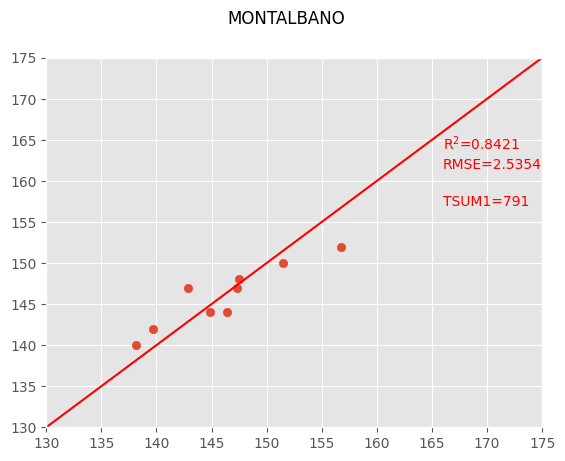

In [33]:
variety='MONTALBANO'

DOY_sim=[]
DOY_obs=[]

for key in list(DOY_obs_dict.keys()):
    plz=int(key[0:4])
    year=int(key[5:9])
    if year>2000:
        DOY_obs.append(DOY_obs_dict[key])
        df=DOY_sim_dict[plz]
        doy=df[df['years']==year]['DOY_sim'].values[0]
        DOY_sim.append(doy)

import matplotlib.pyplot as plt
R2,RMSE=get_stats_sim_vs_obs(DOY_sim,DOY_obs)
fig,ax=plot_WOFOST_model_results(DOY_sim,DOY_obs,R2,RMSE, TSUM1, variety)
figname='WOFOST_model_'+variety+'.png'
fig.savefig(figname,bbox_inches='tight',pad_inches=0)

In [35]:
DOY_obs_dict

{'1260_2016': 147.3333333,
 '8315_2016': 156.75,
 '1567_2016': 151.5,
 '1260_2017': 139.6666667,
 '8315_2017': 147.5,
 '1260_2018': 138.12041957894735,
 '1040_2018': 142.86528496666668,
 '8566_2018': 144.898497,
 '8315_2018': 146.408746475}

In [38]:
variety='ARINA'
pheno_calib=read_data_Fossati(variety)
obs=prep_data_for_calib(pheno_calib)

In [39]:
obs

{'3428_2000': 146.9,
 '1510_2000': 149.0,
 '1260_2000': 145.0,
 '8046_2000': 146.9,
 '1042_2000': 152.8,
 '8566_2000': 150.9,
 '1725_2000': 152.3,
 '4702_2000': 147.1,
 '1567_2000': 152.2,
 '1510_2001': 151.0,
 '1260_2001': 148.7,
 '1042_2001': 156.6,
 '1725_2001': 153.3,
 '1510_2002': 156.0,
 '1260_2002': 153.0,
 '1042_2002': 156.5,
 '1725_2002': 159.3,
 '3428_2003': 148.3,
 '1510_2003': 151.7,
 '1260_2003': 144.7,
 '8566_2003': 152.0,
 '4702_2003': 153.3,
 '1567_2003': 151.0,
 '1510_2004': 156.0,
 '1260_2004': 149.3,
 '1042_2004': 157.1,
 '1725_2004': 160.9,
 '1510_2005': 156.5,
 '1260_2005': 153.7,
 '1042_2005': 165.4,
 '1725_2005': 162.1,
 '3428_2006': 161.1,
 '1510_2006': 154.7,
 '1260_2006': 148.0,
 '1042_2006': 161.9,
 '8566_2006': 162.9,
 '1725_2006': 161.7,
 '1567_2006': 156.3,
 '3428_2007': 140.6200786,
 '1510_2007': 133.9806254,
 '1260_2007': 132.38387885,
 '1042_2007': 142.68333335,
 '8052_2007': 141.39774119999998,
 '8566_2007': 141.20070859999998,
 '1725_2007': 141.915502